In [2]:
import pandas as pd
import numpy as np
import string

In [3]:
products = pd.read_csv('../course_3_data/amazon_baby_subset.csv')

In [4]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [5]:
def remove_punctuation(text):
    return text.translate(str.maketrans('','', string.punctuation))

In [6]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [15]:
important_words = pd.read_json('../course_3_data/important_words.json')

In [16]:
for word in important_words[0]: 
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [17]:
products.shape

(53072, 198)

In [18]:
train_idx = pd.read_json('../course_3_data/module-10-assignment-train-idx.json')
valid_idx = pd.read_json('../course_3_data/module-10-assignment-validation-idx.json')

In [19]:
train_data = products.iloc[train_idx[0]]
validation_data = products.iloc[valid_idx[0]]

In [20]:
train_data.shape

(47780, 198)

In [21]:
def get_numpy_data(dataframe, features, label):
    dataframe.loc[:,'constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [22]:
words=list(important_words[0].values)

In [23]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, words, 'sentiment')

/home/prachi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/prachi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))

    # return predictions
    return predictions

In [25]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors,feature)
        # Return the derivative
    return derivative

In [26]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

In [27]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print( "Gradient single data point: %s" % gradient_single_data_point)
print( "           --> Should print 0.0")

print(indicator)
print(feature_matrix_train[i:i+B,j])

Gradient single data point: 0.0
           --> Should print 0.0
[ True]


NameError: name 'B' is not defined

In [28]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print( "Gradient mini-batch data points: %s" % gradient_mini_batch)
print( "                --> Should print 1.0")
print(indicator)
print(feature_matrix_train[i:i+B,j])

Gradient mini-batch data points: 1.0
                --> Should print 1.0
[ True  True  True  True  True  True  True  True  True  True]
[0 1 1 0 0 0 0 0 0 0]


* Create an empty list called log_likelihood_all
* Initialize coefficients to initial_coefficients
* Set random seed = 1
* Shuffle the data before starting the loop below
* Set i = 0, the index of current batch

* Run the following steps max_iter times, performing linear scans over the data:
  * Predict P(y_i = +1|x_i,w) using your predict_probability() function
    Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
  * Compute indicator value for (y_i = +1)
    Make sure to slice the i-th entry with [i:i+batch_size]
  * Compute the errors as (indicator - predictions)
  * For each coefficients[j]:
    - Compute the derivative for coefficients[j] and save it to derivative.
      Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
    - Compute the product of the step size, the derivative, and (1./batch_size).
    - Increment coefficients[j] by the product just computed.
  * Compute the average log likelihood over the current batch.
    Add this value to the list log_likelihood_all.
  * Increment i by batch_size, indicating the progress made so far on the data.
  * Check whether we made a complete pass over data by checking
    whether (i+batch_size) exceeds the data size. If so, shuffle the data. If not, do nothing.

* Return the final set of coefficients, along with the list log_likelihood_all.

In [29]:
# def logistic_regression_SG(feature_matrix,sentiment,initial_coefficients,step_size,batch_size,max_iter):
#     log_likelihood_all=[]
#     coefficients = np.array(initial_coefficients)
#     np.random.seed(seed=1)
    
#     shuffle = np.random.permutation(len(feature_matrix))
#     feature_matrix = feature_matrix[shuffle,:]
#     sentiment = sentiment[shuffle]
    
#     i=0
    
#     for itr in range(max_iter):
#         predictions=predict_probability(feature_matrix[i:i+batch_size,:],coefficients)
#         indicator = (sentiment[i:i+batch_size]== +1)
#         error = indicator - predictions
#         for j in range(len(coefficients)):
#             derivative = feature_derivative(error,feature_matrix[i:i+batch_size,:])
#             coefficients[j] += (1/batch_size)*(step_size * derivative)
        
#         lp=compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:],sentiment[i:i+batch_size],coefficients)
#         log_likelihood_all.append(lp)
        
#         i+=batch_size
        
#         if i+batch_size>len(feature_matrix):
#             shuffle = np.random.permutation(len(feature_matrix))
#             feature_matrix = feature_matrix[shuffle]
#             sentiment = sentiment[shuffle]
#             i=0
            
#     return coefficients,log_likelihood_all
    

In [30]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += (1./batch_size)*(step_size * derivative)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print( 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [31]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10

In [32]:
stochastic_coeff,stochastic_loglikelihood = logistic_regression_SG(feature_matrix_train,sentiment_train,
                                                                  initial_coefficients,
                                                                  step_size,
                                                                  batch_size,
                                                                  max_iter)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


In [33]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = len(train_data)
max_iter = 200

In [34]:
batch_coeff,batch_loglikelihood = logistic_regression_SG(feature_matrix_train,sentiment_train,
                                                                  initial_coefficients,
                                                                  step_size,
                                                                  batch_size,
                                                                  max_iter)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

In [35]:
step_size=1e-1
batch_size=100
initial_coefficients =  np.zeros(194)
max_iter = 10*int(len(feature_matrix_train)/batch_size)

In [36]:
m1_coeff,m1_loglikelihood = logistic_regression_SG(feature_matrix_train,sentiment_train,
                                                                  initial_coefficients,
                                                                  step_size,
                                                                  batch_size,
                                                                  max_iter)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

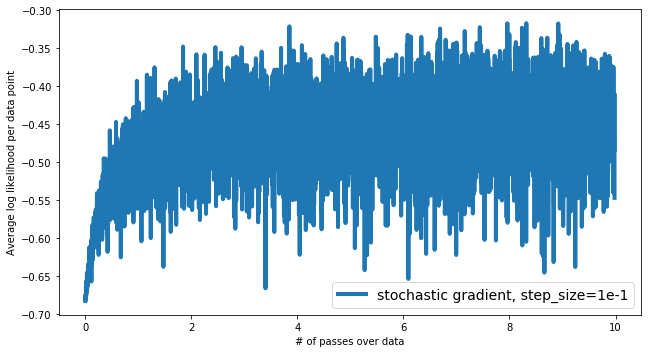

In [38]:
make_plot(m1_loglikelihood,len(train_data),batch_size,smoothing_window=1,label='stochastic gradient, step_size=1e-1')

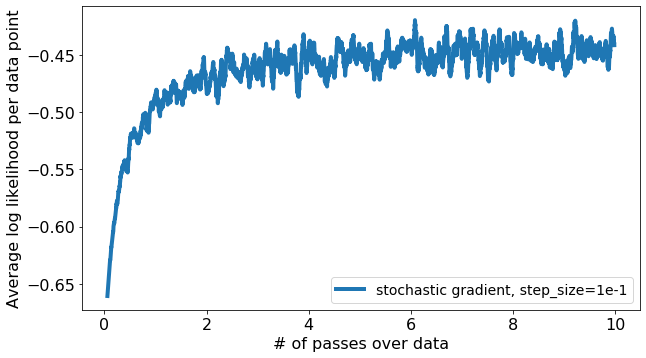

In [39]:
make_plot(m1_loglikelihood,len(train_data),batch_size,smoothing_window=30,label='stochastic gradient, step_size=1e-1')

In [40]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points in b

In [45]:
log_likelihood_sgd

{0.0001: [-0.6931362183867823,
  -0.6931316963905388,
  -0.6931358483573713,
  -0.6931248694909509,
  -0.693131568850746,
  -0.693131128295915,
  -0.6931112050714383,
  -0.693126916271044,
  -0.6931211458191292,
  -0.6931281063634246,
  -0.6931128597792319,
  -0.6931030057523182,
  -0.6931072507525449,
  -0.6931156724181605,
  -0.6931083608771762,
  -0.693083415344691,
  -0.6931228571351281,
  -0.6930842265850877,
  -0.6931161637769285,
  -0.6931039669392333,
  -0.6930990147739853,
  -0.6931001388739578,
  -0.6931020482874725,
  -0.6931104466468018,
  -0.6930770564038227,
  -0.6930837465266066,
  -0.6930947204810367,
  -0.6930869234481548,
  -0.6931030939437852,
  -0.6930661647291834,
  -0.6930923968859111,
  -0.6930793362219808,
  -0.6930859572430472,
  -0.6930819475562877,
  -0.6930784207774002,
  -0.6930471637073176,
  -0.693049313013787,
  -0.693092314457438,
  -0.6930404367841032,
  -0.693093548087371,
  -0.6930708233160553,
  -0.6930431582436088,
  -0.6930455855770237,
  -0.69304

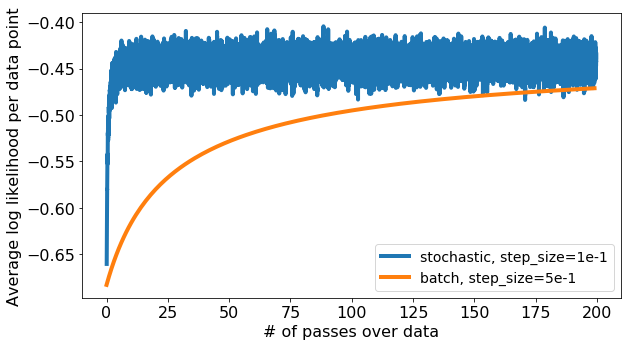

In [41]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(batch_loglikelihood, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

In [42]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -0.56306510
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900

Iteration 4000: Average log likelihood (of data points in batch [18400:18500]) = -2.47834692
Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -2.48776279
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -2.44471310
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -36.66862050
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -25.49870239
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -40.14565040
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -27.03748522
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -32.62294582
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -25.88017915
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -37.30720216
Iteration    8: Average log likelihood (of data points in batch

/home/prachi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/prachi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


Iteration  100: Average log likelihood (of data points in batch [10000:10100]) = -10.64501704
Iteration  200: Average log likelihood (of data points in batch [20000:20100]) = -4.03748131
Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -3.83037593
Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -3.14931563
Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -4.80508816
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -17.33121209
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -8.33353486
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -4.52307543
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -3.04990545
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -2.84706421
Iteration 2000: Average log likelihood (of data points in batch [092

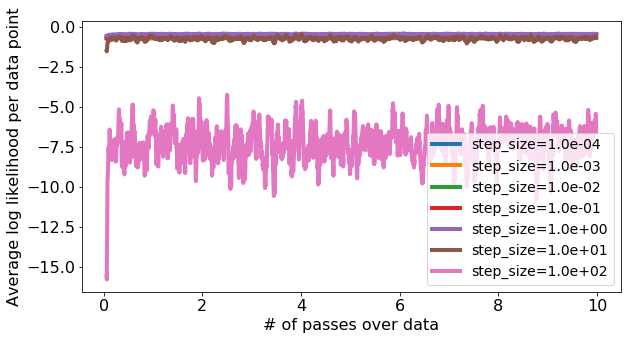

In [43]:

for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)